<a href="https://colab.research.google.com/github/pharringtonp19/mecon/blob/main/notebooks/practice_final/SIF.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [9]:
#@title **Imports** { display-mode: "form" }
import jax 
jax.config.update("jax_enable_x64", True)
import jax.numpy as jnp 
from functools import partial 
import matplotlib as mpl
from matplotlib import pyplot as plt
from mpl_toolkits import mplot3d
from matplotlib import rcParams
rcParams['image.interpolation'] = 'nearest'
rcParams['image.cmap'] = 'viridis'
rcParams['axes.grid'] = False
%matplotlib inline
%config InlineBackend.figure_format = 'svg'

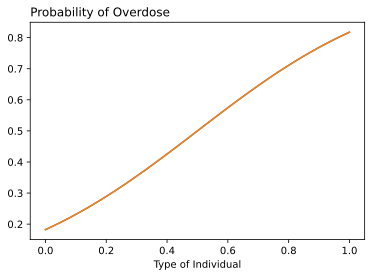

In [34]:
#@title **Probability of Overdose** { display-mode: "form" }
def probability_overdose(level, sif):
  return jax.nn.sigmoid(3*(level - 0.5))

levels = jnp.linspace(0, 1, 100)                                                # Vector of linearly spaces values between 0 and 1 
for i in [0., 1.]:                                                              # For loop over the values for sif 
  prob_overdose_partial = partial(probability_overdose, sif=i)                  # Partially Evaluate the probability function 
  prob_overdose_partial_vecotize = jax.vmap(prob_overdose_partial)              # Vectorize the function 
  ps = prob_overdose_partial_vecotize(levels)                                   # Vector of probabilities 
  plt.plot(levels, ps, label=i)                                                 # Plot the vectors 
plt.title('Probability of Overdose', loc='left')
plt.xlabel('Type of Individual')
plt.show()

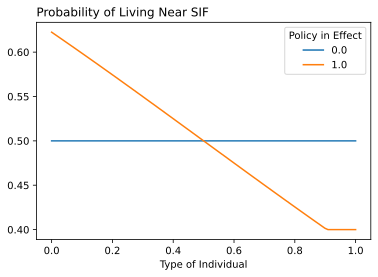

In [83]:
#@title **Probability of Living Near Facility**
def probability_sif(level, t):
  """t=1 means policy is in effect"""
  p = 0.5
  v = jax.nn.sigmoid(((1-level) - 0.5))
  return jnp.where(t==0, p, jnp.maximum(v, 0.4))

levels = jnp.linspace(0, 1, 100)                                                # Vector of linearly spaces values between 0 and 1 
for i in [0., 1.]:                                                              # For loop over the values for sif 
  probability_sif_partial = partial(probability_sif, t=i)                       # Partially Evaluate the probability function 
  probability_sif_partial_vecotize = jax.vmap(probability_sif_partial)          # Vectorize the function 
  ps = probability_sif_partial_vecotize(levels)                                 # Vector of probabilities 
  plt.plot(levels, ps, label=i)                                                 # Plot the vectors 
plt.title('Probability of Living Near SIF', loc='left')
plt.xlabel('Type of Individual')
plt.legend(title='Policy in Effect')
plt.show()

In [84]:
#@title **Sample Observation**
def sample(key, t):
  subkey1, subkey2, subkey3 = jax.random.split(key, 3)                                                          # Create more keys from initial key
  level = jax.random.uniform(subkey1, minval=0., maxval=1.)                                                     # Sample the type of individual 
  prob_sif = probability_sif(level, t)                                                                          # Probability of living near the facility 
  sif = jax.random.choice(subkey2, jnp.array([0., 1.]), p=jnp.array([1-prob_sif, prob_sif]))                    # Indicator for living near the facility
  prob_overdose = probability_overdose(level, sif)                                                              # Probability of overdose 
  overdose = jax.random.choice(subkey3, jnp.array([0., 1.]), p=jnp.array([1-prob_overdose, prob_overdose]))     # Indicator for overdose
  return overdose, sif 

In [90]:
#@title **Sample and Estimate** { display-mode: "form" }
def sample_and_estimate(key):
  subkey1, subkey2 = jax.random.split(key)
  pre_policy_overdose,  pre_policy_sif = jax.vmap(partial(sample,t=0))(jax.random.split(subkey1, 500))
  post_policy_overdose,  post_policy_sif = jax.vmap(partial(sample,t=1))(jax.random.split(subkey2, 500))
  
  pre_sif0_rate = jnp.mean(pre_policy_overdose, where=pre_policy_sif==0)
  post_sif0_rate = jnp.mean(post_policy_overdose, where=post_policy_sif==0)

  pre_sif1_rate = jnp.mean(pre_policy_overdose, where=pre_policy_sif==1)
  post_sif1_rate = jnp.mean(post_policy_overdose, where=post_policy_sif==1)

  sif1_effect = post_sif1_rate - pre_sif1_rate
  sif0_effect = post_sif0_rate - pre_sif0_rate
  return sif1_effect - sif0_effect

In [91]:
#@title **Simulate Data** { display-mode: "form" }
keys = jax.random.split(jax.random.PRNGKey(0), 5000)                            # Vector of Keys 
sample_and_estimate_vector = jax.vmap(sample_and_estimate)                      # Vectorize the function 
estimates = sample_and_estimate_vector(keys)                                    # Vector of Estimates 

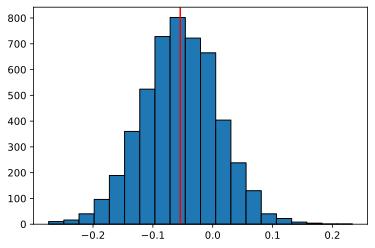

In [92]:
#@title **Plot Sampling Distribution** { display-mode: "form" }
plt.hist(estimates, edgecolor='black', bins=20)
plt.axvline(jnp.mean(estimates), color='red')
plt.show()